## 数据准备

In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
np.random.seed(42)

In [3]:
#数据集位置
gtzan_dir = '../data/genres_original'

In [4]:
#分类标签
genres = {
    'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3,
    'jazz': 4, 'country': 5, 'pop': 6, 'blues': 7,
    'reggae': 8, 'rock': 9
}

## 提取特征

In [5]:
def get_features(y, sr, n_fft=1024, hop_length=512):
    """
    提取音频特征
    :param y: 音频时间序列
    :param sr: 采样率
    :param n_fft: FFT窗口大小
    :param hop_length: 帧移
    :return: 包含统计特征和节奏的字典
    """
    features = {
        'centroid': librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
        'rmse': librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length).ravel(),
        'contrast': librosa.feature.spectral_contrast(y=y, sr=sr).ravel()
    }

    # 提取MFCC特征
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features[f'mfcc_{idx}'] = v_mfcc.ravel()

    # 计算统计特征
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result[f'{k}_max'] = np.max(v)
            result[f'{k}_min'] = np.min(v)
            result[f'{k}_mean'] = np.mean(v)
            result[f'{k}_std'] = np.std(v)
            result[f'{k}_kurtosis'] = kurtosis(v)
            result[f'{k}_skew'] = skew(v)
        return result

    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y=y, sr=sr)[0]  # 计算节奏

    return dict_agg_features

In [6]:
import torchaudio

def read_process_songs(src_dir, debug=True):
    arr_features = []

    for genre_name, genre_id in genres.items():
        folder = os.path.join(src_dir, genre_name)
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = os.path.join(folder, file)

                try:
                    signal, sr = torchaudio.load(file_name)
                    if debug:
                        print("正在读取文件: {}".format(file_name))
                    features = get_features(signal.numpy(), sr)
                    features['genre'] = genre_id
                    arr_features.append(features)
                except Exception as e:
                    print(f"读取文件时出错 {file_name}: {e}")
    return arr_features

In [7]:
features = read_process_songs(gtzan_dir, debug=True)

正在读取文件: ../data/genres_original\metal\metal.00000.wav


C:\Users\33079\AppData\Local\Temp\ipykernel_5468\3832347490.py:34: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  dict_agg_features['tempo'] = librosa.beat.tempo(y=y, sr=sr)[0]  # 计算节奏


正在读取文件: ../data/genres_original\metal\metal.00001.wav
正在读取文件: ../data/genres_original\metal\metal.00002.wav
正在读取文件: ../data/genres_original\metal\metal.00003.wav
正在读取文件: ../data/genres_original\metal\metal.00004.wav
正在读取文件: ../data/genres_original\metal\metal.00005.wav
正在读取文件: ../data/genres_original\metal\metal.00006.wav
正在读取文件: ../data/genres_original\metal\metal.00007.wav
正在读取文件: ../data/genres_original\metal\metal.00008.wav
正在读取文件: ../data/genres_original\metal\metal.00009.wav
正在读取文件: ../data/genres_original\metal\metal.00010.wav
正在读取文件: ../data/genres_original\metal\metal.00011.wav
正在读取文件: ../data/genres_original\metal\metal.00012.wav
正在读取文件: ../data/genres_original\metal\metal.00013.wav
正在读取文件: ../data/genres_original\metal\metal.00014.wav
正在读取文件: ../data/genres_original\metal\metal.00015.wav
正在读取文件: ../data/genres_original\metal\metal.00016.wav
正在读取文件: ../data/genres_original\metal\metal.00017.wav
正在读取文件: ../data/genres_original\metal\metal.00018.wav
正在读取文件: ../data/genres_origi

## 数据展示

In [8]:
df_features = pd.DataFrame(features)

In [9]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,rmse_max,rmse_min,rmse_mean,rmse_std,...,contrast_kurtosis,contrast_skew,mfcc_0_max,mfcc_0_min,mfcc_0_mean,mfcc_0_std,mfcc_0_kurtosis,mfcc_0_skew,tempo,genre
0,5514.393291,1789.366580,3177.044739,550.514460,1.276833,0.851272,0.190168,0.068968,0.115590,0.020466,...,4.510000,2.099199,94.322510,-193.552979,0.595384,42.164688,4.380595,-1.837860,[95.703125],0
1,5626.545399,1763.465455,2850.278392,450.497575,7.135793,1.871643,0.152074,0.051751,0.096836,0.017310,...,1.597136,1.681416,104.749687,-221.079575,-0.275020,50.393780,4.586694,-1.963454,[151.99908088235293],0
2,4137.382285,1196.751464,2147.080162,394.532048,3.597655,1.475513,0.237120,0.043694,0.132138,0.028337,...,1.195806,1.499634,163.077271,-261.921478,-0.740221,56.561096,2.064131,-0.396943,[112.34714673913044],0
3,4141.859835,1554.571720,2700.604011,411.344742,-0.256947,0.124514,0.251725,0.052029,0.148656,0.036034,...,1.429011,1.665201,117.683540,-207.158676,1.311448,47.345032,1.356641,-0.851918,[99.38401442307692],0
4,6472.152592,2069.514147,3357.388866,548.511977,1.316818,0.691419,0.103934,0.002907,0.062903,0.013288,...,2.157973,1.747947,96.968018,-444.727875,-3.099242,55.875771,8.220078,-2.732435,[135.99917763157896],0


## 标签检查

In [10]:
df_features.to_csv('../data/features_30_sec.csv', index=False)

In [11]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values
# 检查样本数量是否一致
if X.shape[0] == y.shape[0]:
    print("X 和 y 的样本数量一致")
else:
    print("X 和 y 的样本数量不一致，需要检查数据")
if X.shape[1] == 0:
    print("特征数量为 0，需要检查删除操作")
else:
    print("特征数量:", X.shape[1])

X 和 y 的样本数量一致
特征数量: 25


## 划分及处理

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 假设 X 是特征矩阵，y 是标签
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
# 初始化 MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # 缩放到 [0, 1] 范围

# 对训练集拟合并转换
X_train_scaled = scaler.fit_transform(X_train)

# 对测试集仅转换（使用训练集的最小值和最大值）
X_test_scaled = scaler.transform(X_test)

In [28]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 决策树

In [29]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [30]:
preds = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.4486
best score on test set (accuracy) = 0.4440


D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


## 随机森林

In [31]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

In [17]:
preds = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5714
best score on test set (accuracy) = 0.6280


D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


## 逻辑回归

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from lightgbm import LGBMClassifier

# 使用更合理的 LightGBM 参数
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=5,          # 增加树的深度
    min_child_samples=20, # 减少叶子节点最小样本数
    learning_rate=0.1,    # 提高学习率
    num_leaves=31,        # 增加叶子节点数
    reg_alpha=0,          # 降低 L1 正则化
    reg_lambda=0,         # 降低 L2 正则化
    verbose=-1            # 关闭 LightGBM 日志
)



pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('feature_selection', SelectFromModel(lgbm_model)),
    ('cls', LogisticRegression())
])
pipe_lr.set_params(feature_selection__estimator=lgbm_model)
#l1 l2正则化
# 定义参数网格
params = {
    "cls__penalty": ["l2"],
    "cls__C": [0.5, 1, 2, 5],
    "cls__max_iter": [500],
}

# 网格搜索
grid_lr = GridSearchCV(pipe_lr, param_grid=params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)



D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(max_depth=5,
                                                                                 reg_alpha=0,
                                                                                 reg_lambda=0,
                                                                                 verbose=-1))),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5], 'cls__max_iter': [500],
                         'cls__penalty': ['l2']},
             scoring='accuracy')

In [19]:
preds = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5660
best score on test set (accuracy) = 0.6000


D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


## svm

In [33]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [34]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5807
best score on test set (accuracy) = 0.6320


D:\conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


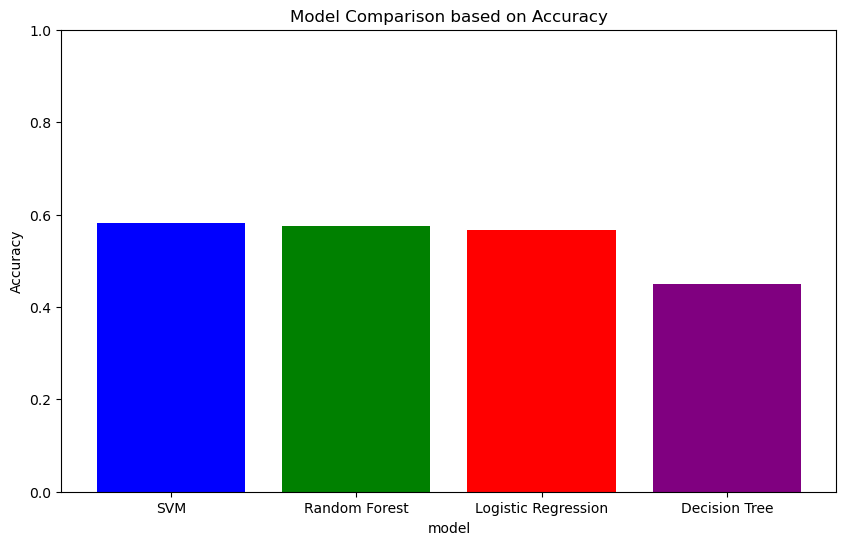

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# 假设已经训练了模型并获取了它们的最佳得分
best_scores = {
    'Logistic Regression': grid_lr.best_score_,  # 逻辑回归的最佳得分
    'Decision Tree': grid_cart.best_score_,      # 决策树的最佳得分
    'Random Forest': grid_rf.best_score_,        # 随机森林的最佳得分
    'SVM': grid_svm.best_score_                  # 支持向量机的最佳得分
}

# 按最佳得分对模型进行排序
sorted_scores = sorted(best_scores.items(), key=lambda x: x[1], reverse=True)
models, scores = zip(*sorted_scores)  # 解包模型名称和得分

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'green', 'red', 'purple'])  # 设置颜色
plt.xlabel('model')  # x轴标签
plt.ylabel('Accuracy')  # y轴标签
plt.title('Model Comparison based on Accuracy')  # 图表标题
plt.ylim(0, 1)  # 设置y轴范围，假设准确率在0到1之间
plt.show()

## svm混淆矩阵

In [36]:
cm = confusion_matrix(y_test, preds)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

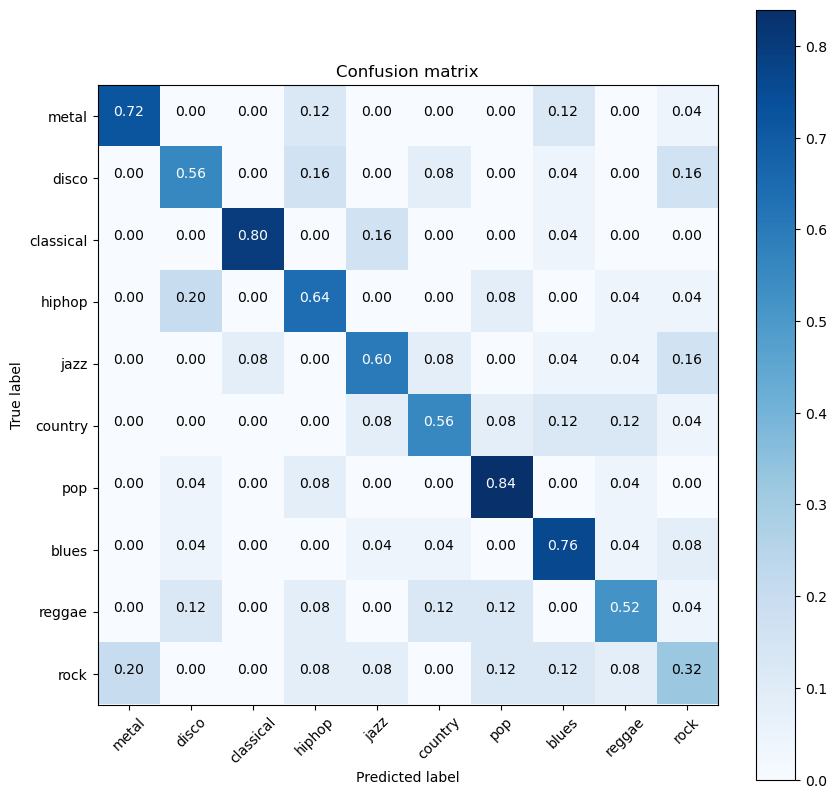

In [37]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

## 原模型保存

In [25]:
import joblib
joblib.dump(grid_svm, "../models/svm.joblib.m")

['../models/svm.joblib.m']

## 调参

In [38]:
from sklearn.model_selection import cross_val_score
# 初筛
pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

# 设置 Pipeline 输出为 pandas.DataFrame（可选）
pipe_svm.set_output(transform="pandas")

# 定义参数范围
C_values = [0.1, 0.5, 1, 2, 5, 10, 100]
kernel_values = ['rbf', 'linear', 'sigmoid', 'poly']

# 初始化最佳参数和最佳得分
best_score = 0
best_params = {'C': None, 'kernel': None}

# 遍历参数组合
for C in C_values:
    for kernel in kernel_values:
        # 设置参数
        pipe_svm.set_params(cls__C=C, cls__kernel=kernel)

        # 使用交叉验证评估模型性能
        scores = cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # 打印当前参数组合和得分
        print(f"C: {C}, Kernel: {kernel}, Mean Accuracy: {mean_score:.4f}")

        # 更新最佳参数
        if mean_score > best_score:
            best_score = mean_score
            best_params['C'] = C
            best_params['kernel'] = kernel

# 输出最佳参数和得分
print(f"\nBest Parameters: C={best_params['C']}, Kernel={best_params['kernel']}")
print(f"Best Mean Accuracy: {best_score:.4f}")

# 使用最佳参数重新训练模型
pipe_svm.set_params(cls__C=best_params['C'], cls__kernel=best_params['kernel'])
pipe_svm.fit(X_train, y_train)

# 在测试集上评估模型
y_pred = pipe_svm.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


C: 0.1, Kernel: rbf, Mean Accuracy: 0.4939
C: 0.1, Kernel: linear, Mean Accuracy: 0.5313
C: 0.1, Kernel: sigmoid, Mean Accuracy: 0.4112
C: 0.1, Kernel: poly, Mean Accuracy: 0.3672
C: 0.5, Kernel: rbf, Mean Accuracy: 0.5380
C: 0.5, Kernel: linear, Mean Accuracy: 0.5473
C: 0.5, Kernel: sigmoid, Mean Accuracy: 0.4245
C: 0.5, Kernel: poly, Mean Accuracy: 0.4553
C: 1, Kernel: rbf, Mean Accuracy: 0.5634
C: 1, Kernel: linear, Mean Accuracy: 0.5473
C: 1, Kernel: sigmoid, Mean Accuracy: 0.4031
C: 1, Kernel: poly, Mean Accuracy: 0.4980
C: 2, Kernel: rbf, Mean Accuracy: 0.5807
C: 2, Kernel: linear, Mean Accuracy: 0.5513
C: 2, Kernel: sigmoid, Mean Accuracy: 0.3831
C: 2, Kernel: poly, Mean Accuracy: 0.5460
C: 5, Kernel: rbf, Mean Accuracy: 0.5727
C: 5, Kernel: linear, Mean Accuracy: 0.5473
C: 5, Kernel: sigmoid, Mean Accuracy: 0.3683
C: 5, Kernel: poly, Mean Accuracy: 0.5553
C: 10, Kernel: rbf, Mean Accuracy: 0.5887
C: 10, Kernel: linear, Mean Accuracy: 0.5487
C: 10, Kernel: sigmoid, Mean Accuracy

In [39]:
from sklearn.model_selection import cross_val_score
# 初筛
pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

# 设置 Pipeline 输出为 pandas.DataFrame（可选）
pipe_svm.set_output(transform="pandas")

# 定义参数范围
C_values = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kernel_values = ['rbf', 'linear', 'sigmoid', 'poly']

# 初始化最佳参数和最佳得分
best_score = 0
best_params = {'C': None, 'kernel': None}

# 遍历参数组合
for C in C_values:
    for kernel in kernel_values:
        # 设置参数
        pipe_svm.set_params(cls__C=C, cls__kernel=kernel)

        # 使用交叉验证评估模型性能
        scores = cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # 打印当前参数组合和得分
        print(f"C: {C}, Kernel: {kernel}, Mean Accuracy: {mean_score:.4f}")

        # 更新最佳参数
        if mean_score > best_score:
            best_score = mean_score
            best_params['C'] = C
            best_params['kernel'] = kernel

# 输出最佳参数和得分
print(f"\nBest Parameters: C={best_params['C']}, Kernel={best_params['kernel']}")
print(f"Best Mean Accuracy: {best_score:.4f}")

# 使用最佳参数重新训练模型
pipe_svm.set_params(cls__C=best_params['C'], cls__kernel=best_params['kernel'])
pipe_svm.fit(X_train, y_train)

# 在测试集上评估模型
y_pred = pipe_svm.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


C: 3, Kernel: rbf, Mean Accuracy: 0.5861
C: 3, Kernel: linear, Mean Accuracy: 0.5527
C: 3, Kernel: sigmoid, Mean Accuracy: 0.3724
C: 3, Kernel: poly, Mean Accuracy: 0.5487
C: 4, Kernel: rbf, Mean Accuracy: 0.5767
C: 4, Kernel: linear, Mean Accuracy: 0.5513
C: 4, Kernel: sigmoid, Mean Accuracy: 0.3737
C: 4, Kernel: poly, Mean Accuracy: 0.5567
C: 5, Kernel: rbf, Mean Accuracy: 0.5727
C: 5, Kernel: linear, Mean Accuracy: 0.5473
C: 5, Kernel: sigmoid, Mean Accuracy: 0.3683
C: 5, Kernel: poly, Mean Accuracy: 0.5553
C: 6, Kernel: rbf, Mean Accuracy: 0.5767
C: 6, Kernel: linear, Mean Accuracy: 0.5473
C: 6, Kernel: sigmoid, Mean Accuracy: 0.3737
C: 6, Kernel: poly, Mean Accuracy: 0.5606
C: 7, Kernel: rbf, Mean Accuracy: 0.5780
C: 7, Kernel: linear, Mean Accuracy: 0.5487
C: 7, Kernel: sigmoid, Mean Accuracy: 0.3591
C: 7, Kernel: poly, Mean Accuracy: 0.5660
C: 8, Kernel: rbf, Mean Accuracy: 0.5860
C: 8, Kernel: linear, Mean Accuracy: 0.5474
C: 8, Kernel: sigmoid, Mean Accuracy: 0.3644
C: 8, Kern

In [ ]:
import joblib
joblib.dump(grid_svm, "../models/svm.joblib.m")